### Packages loading

In [39]:
import numpy as np
import random
import qiskit
import qtm.evolution
import qtm.state
import qtm.qcompilation
import qtm.ansatz
import qtm.constant
from qtm.evolution import environment, mutate, selection, crossover
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Quantum architecture search for quantum state preparation problem

Now, we defind the problem which is need to solve

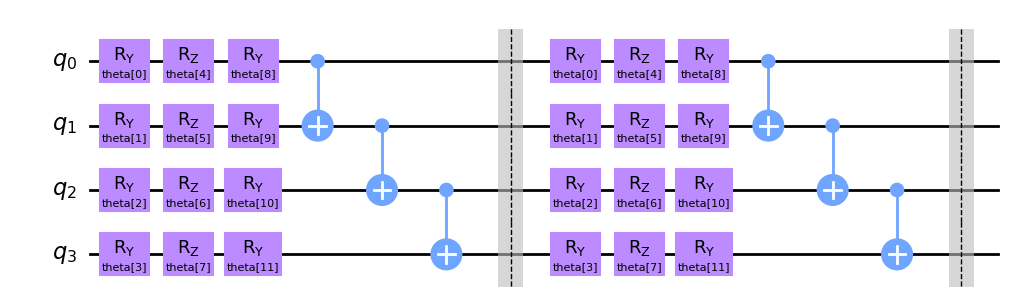

In [51]:
n_qubits=4
n=3
theta = qiskit.circuit.ParameterVector('theta',n*n_qubits)
#theta = np.random.rand(n*n_qubits)
#print(theta)
qc = qiskit.QuantumCircuit(n_qubits)
#theta = [0,1,2]
for j in range (2):
    for i in range(n_qubits):
        qc.ry(theta[i], i)
    for i in range(n_qubits):
        qc.rz(theta[i+n+1], i)
    for i in range(n_qubits):
        qc.ry(theta[i+2*(n+1)], i)
    qc.cnot(0, 1)
    qc.cnot(1, 2)
    qc.cnot(2, 3)
    qc.barrier()
qc.draw('mpl')

In [50]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, ParityMapper
from qiskit_nature.units import DistanceUnit

driver = PySCFDriver(
    atom="H 0 0 -0.35; H 0 0 0.35",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()

mapper=JordanWignerMapper()
qubit_converter = QubitConverter(mapper)
qubit_op = qubit_converter.convert(hamiltonian)
print(qubit_op)

-0.7980464206492509 * IIII
- 0.242742805131405 * IIZI
+ 0.17771287465139918 * IIIZ
+ 0.1229330505618381 * IIZZ
+ 0.17771287465139918 * IZII
+ 0.17059738328801052 * IZIZ
+ 0.044750144015351635 * YYYY
+ 0.044750144015351635 * XXYY
+ 0.044750144015351635 * YYXX
+ 0.044750144015351635 * XXXX
- 0.242742805131405 * ZIII
+ 0.16768319457718972 * ZIIZ
+ 0.16768319457718972 * IZZI
+ 0.17627640804319608 * ZIZI
+ 0.1229330505618381 * ZZII


In [45]:

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA, L_BFGS_B

def VQE_fitness(qc: qiskit.QuantumCircuit):
    print(qc)
    backend = Aer.get_backend('aer_simulator')
    quantum_instance = QuantumInstance(backend=backend, shots=1000)
    vqe = VQE(qc, optimizer=SLSQP(maxiter=1000), quantum_instance=quantum_instance, include_custom=True)
    return vqe.compute_minimum_eigenvalue(qubit_op)


Main algorithm, includes: init population, selection, crossover, mutate.

In [46]:
params = {'depth': 10,
          'num_individual': 8,  # Must mod 8 = 0
          'num_generation': 30,
          'num_qubits': 4,
          'threshold': 0.2,
          'prob_mutate': 0.01}

env = environment.EEnvironment(
    params,
    fitness_func = VQE_fitness,
    selection_func = selection.elitist_selection,
    crossover_func= crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool = qtm.constant.operations
)

env.initialize_population()
env.evol() 

                                                                     »
q_0: ───────────────────────■───────────────■────────────────────────»
          ┌───┐             │               │             ┌───┐      »
q_1: ─────┤ Y ├─────────────┼───────────────┼─────────────┤ X ├──────»
          └───┘      ┌──────┴───────┐┌──────┴───────┐┌────┴───┴─────┐»
q_2: ────────────────┤ Rz(theta[1]) ├┤ Rx(theta[2]) ├┤ Ry(theta[5]) ├»
     ┌──────────────┐└────┬───┬─────┘└──────────────┘└──────────────┘»
q_3: ┤ Rx(theta[0]) ├─────┤ H ├──────────────────────────────────────»
     └──────────────┘     └───┘                                      »
c: 4/════════════════════════════════════════════════════════════════»
                                                                     »
«                     ┌──────────────┐┌──────────────┐     ┌───┐      »
«q_0: ────────────────┤ Rx(theta[4]) ├┤ Rx(theta[6]) ├─────┤ X ├──────»
«     ┌──────────────┐└──────┬───────┘├──────────────┤┌────┴───┴─────┐»
«q_

/tmp/ipykernel_12698/1077711464.py:9: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend=backend, shots=1000)
/tmp/ipykernel_12698/1077711464.py:10: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(qc, optimizer=SLSQP(maxiter=1000), quantum_instance=quantum_instance, include_custom=True)


TypeError: CircuitOp does not support QuantumCircuits with ClassicalRegisters.